# ARIMA Continued

In [1]:
# get the S&P 500 data file
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [2]:
# imports
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [5]:
# look at google stock - note this is not logged prices
goog = df[df['Name'] == 'GOOG']['Close']

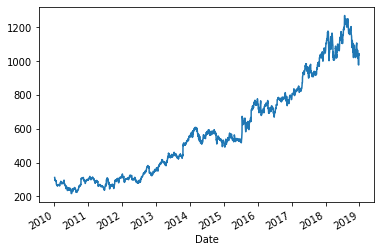

In [6]:
# plot this data
goog.plot();

In [7]:
# reserve last Ntest observations as testing, rest is for training
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [8]:
# create model using auto arima
# this is stepwise and limited to 10 iterations
model = pm.auto_arima(train, 
                      error_action='ignore', 
                      trace=True, 
                      suppress_warnings=True, 
                      maxiter=10, 
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16270.771, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16270.383, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16269.726, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16269.492, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16271.123, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16268.077, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16267.935, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16268.277, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16266.968, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16264.983, Time=0.67 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16266.925, Time=0.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16268.907, Time=1.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16265.470, Time=0.24 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 6.671 seconds


In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8127.491
Date:                Sun, 10 Apr 2022   AIC                          16264.983
Time:                        09:56:59   BIC                          16293.536
Sample:                             0   HQIC                         16275.409
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3104      0.198      1.571      0.116      -0.077       0.698
ar.L1          0.0378      0.012      3.152      0.002       0.014       0.061
ar.L2         -0.0410      0.013     -3.241      0.001      -0.066      -0.016
ar.L3          0.0488      0.012      4.031      0.000       0.025       0.073
sigma2        85.1623      1.033     82.421      0.000      83.137      87.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11790.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# view the parameters of our fitted model
model.get_params()

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (3, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [11]:
# create function to plot results
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]
    
    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
    
    fix, ax = plt.subplots(figsize=(10,5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
    ax.legend();

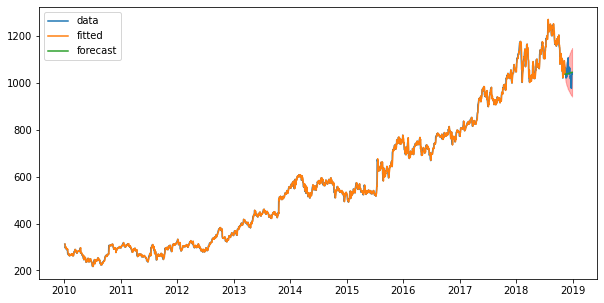

In [12]:
# plot the data with our auto arima model using the plot function
plot_result(model, goog, train, test)

In [13]:
# define another function to focus in on the predictions
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
    
    fix, ax = plt.subplots(figsize=(10,5))
    ax.plot(test.index, test, label='true')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
    ax.legend();

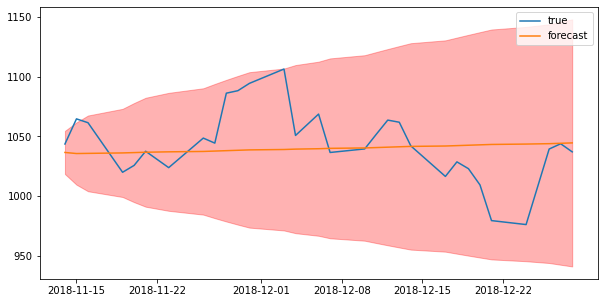

In [14]:
# re-plot, focused on just the predictions
plot_test(model, test)

This forecast is not great.  Our prediction is flat, and doesn't capture the variance of the true series.  However, the actual values all seem to remain inside the confidence interval, and the forecast seems to capture the average value of the series.

In [15]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [17]:
# calc the RMSE of our model and a "naive" model 
# predicting a constant value of the last value in our training data
print("RMSE ARIMA: ", rmse(model.predict(Ntest), test))
print("RMSE Naive: ", rmse(train.iloc[-1], test))

RMSE ARIMA:  30.43660198042493
RMSE Naive:  30.029502477261467


This ARIMA model does not appear to be worth it.  The Naive forecast still wins.

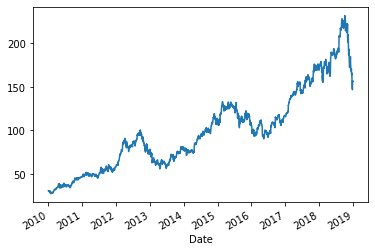

In [18]:
# let's do something similar for Apple
aapl = df[df['Name'] == 'AAPL']['Close']
aapl.plot();

Note that the big drop at the end of this series does not bode well for our modeling here.

In [19]:
train = aapl.iloc[:-Ntest]
test = aapl.iloc[-Ntest:]

In [20]:
model = pm.auto_arima(train, 
                      error_action='ignore', 
                      trace=True, 
                      suppress_warnings=True, 
                      maxiter=10, 
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8570.296, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8575.329, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8574.709, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8574.392, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8577.622, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8571.650, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8571.332, Time=0.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8572.500, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8572.527, Time=0.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8574.574, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8570.852, Time=1.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8570.880, Time=0.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8579.289, Time=1.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8572.973, Time=0.38 sec

Best model:  ARIMA(2,1,2)(0,0,0)

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4279.148
Date:                Sun, 10 Apr 2022   AIC                           8570.296
Time:                        10:14:14   BIC                           8604.560
Sample:                             0   HQIC                          8582.808
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0803      0.042      1.896      0.058      -0.003       0.163
ar.L1          0.3755      0.165      2.279      0.023       0.053       0.699
ar.L2         -0.4239      0.176     -2.407      0.016      -0.769      -0.079
ma.L1         -0.3433      0.172     -2.002      0.045      -0.679      -0.007
ma.L2          0.3579      0.183      1.958      0.050      -0.000       0.716
sigma2         2.7182      0.039     69.453      0.000       2.642       2.795
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6223.04
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.23   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

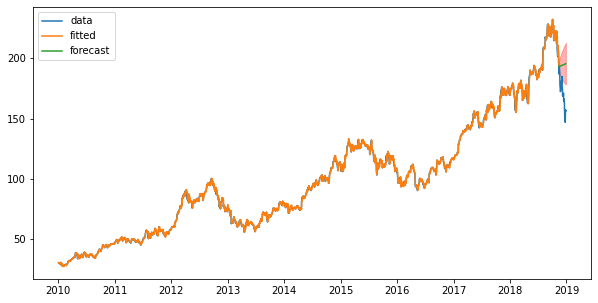

In [23]:
plot_result(model, aapl, train, test)

This looks much worse...

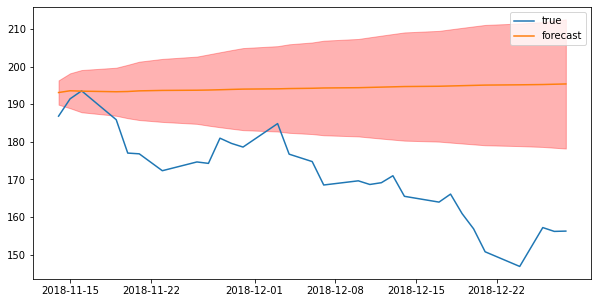

In [24]:
plot_test(model, test)

Definitely not a good model. This model is not going to help us predict a drastic change.

In [25]:
print("RMSE ARIMA: ", rmse(model.predict(Ntest), test))
print("RMSE Naive: ", rmse(train.iloc[-1], test))

RMSE ARIMA:  26.094955708935956
RMSE Naive:  24.02712058667382


Better off to use the Naive model here again.

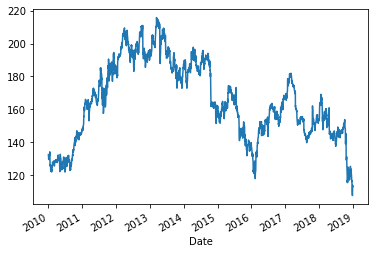

In [26]:
# once more with IBM
ibm = df[df['Name'] == 'IBM']['Close']
ibm.plot();

In [27]:
train = ibm.iloc[:-Ntest]
test = ibm.iloc[-Ntest:]

model = pm.auto_arima(train, 
                      error_action='ignore', 
                      trace=True, 
                      suppress_warnings=True, 
                      maxiter=10, 
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9442.954, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9436.082, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9437.603, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9437.589, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9434.097, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9439.637, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.065 seconds


In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4716.049
Date:                Sun, 10 Apr 2022   AIC                           9434.097
Time:                        10:19:28   BIC                           9439.808
Sample:                             0   HQIC                          9436.183
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.0067      0.055     72.559      0.000       3.898       4.115
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):              5352.76
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.77
Prob(H) (two-sided):                  0.03   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note that the best model here is a random walk

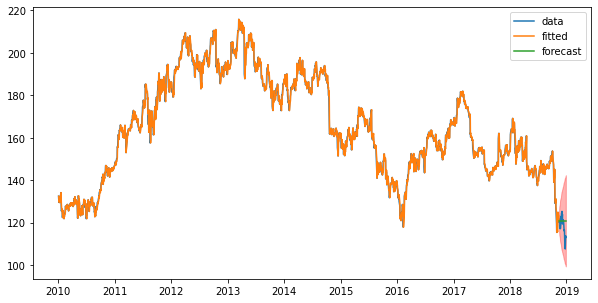

In [29]:
plot_result(model, ibm, train, test)

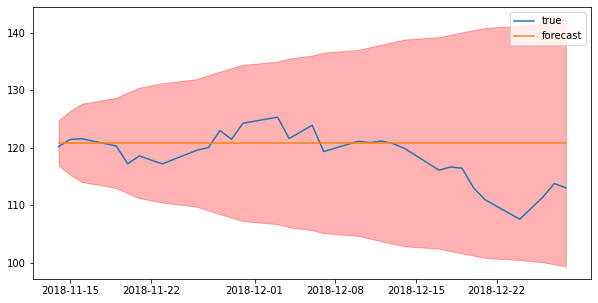

In [30]:
plot_test(model, test)

In [31]:
print("RMSE ARIMA: ", rmse(model.predict(Ntest), test))
print("RMSE Naive: ", rmse(train.iloc[-1], test))

RMSE ARIMA:  4.763157130051095
RMSE Naive:  4.763157130051095
